In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import scipy.stats
import time

In [2]:
# MAY NEED ADJUSTING DEPEDNING ON DEVICE/OS RUNNING
data = pd.read_csv("../../Data/PAUS_866.csv")
data['band'] = data['band'].str.slice(start=2).astype(int)
# Converts 'band' column from type string to int

/home/andrew/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 ### Column 57 mixed type(?)

In [6]:
# data.loc[:1000].to_csv("../../Data/PAUS_866_Reduced.csv")
data.iloc[:,57].loc[data['zfits'].notna()].unique()

array(['zCOSMOS_BRIGHT_DR3_000839801_ZCMRa39_M1_Q1_26_2.fits',
       'zCOSMOS_BRIGHT_DR3_000828896_ZCMRa97_M2_Q1_11_1.fits',
       'zCOSMOS_BRIGHT_DR3_000839358_ZCMRa47_M1_Q2_8_2.fits', ...,
       'zCOSMOS_BRIGHT_DR3_000823392_ZCMRa86_M1_Q4_17_1.fits',
       'zCOSMOS_BRIGHT_DR3_000818119_ZCMRa53_M2_Q2_19_1.fits',
       'zCOSMOS_BRIGHT_DR3_000825415_ZCMRa56_M1_Q4_27_1.fits'],
      dtype=object)

### Creating new data frame of | ref_id_1 | z_photo | z_spec |
(Not all objects have z_spec info)

In [65]:
z_photo = []
z_spec = []

data_nonan = data.loc[(data['ref_id_1'].notna())&(data['zspec'].notna())&(data['zspec']!=0)]

# object_ids = data_nonan['ref_id_1'].unique()

truth_table = data_nonan['ref_id_1'].iloc[1:].values != data_nonan['ref_id_1'].iloc[:-1].values
truth_table = np.append(truth_table, [True])

object_ids, z_photo, z_spec = data_nonan.loc[truth_table]['ref_id_1'].values,\
                                data_nonan.loc[truth_table]['zb'].values,\
                                data_nonan.loc[truth_table]['zspec'].values
    
datasetup = {'ref_id_1':object_ids,'z_photo':z_photo,'z_spec':z_spec}
objects_zbs_df = pd.DataFrame(datasetup)

objects_zbs_df.to_pickle\
        ("../../Data/Object_zs_zp{}.pkl.gz".format(time.strftime("_%y%m%d_%H%M%S")),"gzip")

In [66]:
# Generating df with object_id - zphoto - zspec
# Has been saved to data folder so can be read from "Object_zs_zp.pkl.gz"

objects_zbs_df = pd.read_pickle("../../Data/Object_zs_zp_181109_151402.pkl.gz")

objects_zbs_df


,ref_id_1,z_photo,z_spec
0,89945.0,0.719,0.7357
1,64435.0,0.319,0.3277
2,89955.0,0.771,0.7364
3,89963.0,0.802,0.7975
4,89969.0,0.721,0.7338
5,89973.0,0.832,0.7309
6,89975.0,0.941,0.9765
7,95379.0,0.482,0.4813
8,89987.0,0.284,0.2833
9,89997.0,0.676,0.6675


# SED

In [3]:
luminosity_distances = cosmo.luminosity_distance(data.loc[data['zb'].notna()]['zb']).value
bands = data.loc[data['zb'].notna()]['band']
z_photos = data.loc[data['zb'].notna()]['zb']
object_ids = data.loc[data['zb'].notna()]['ref_id_2']
fluxs = data.loc[data['zb'].notna()]['flux']

#GENERATE Luminosity Distances

/home/andrew/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/andrew/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


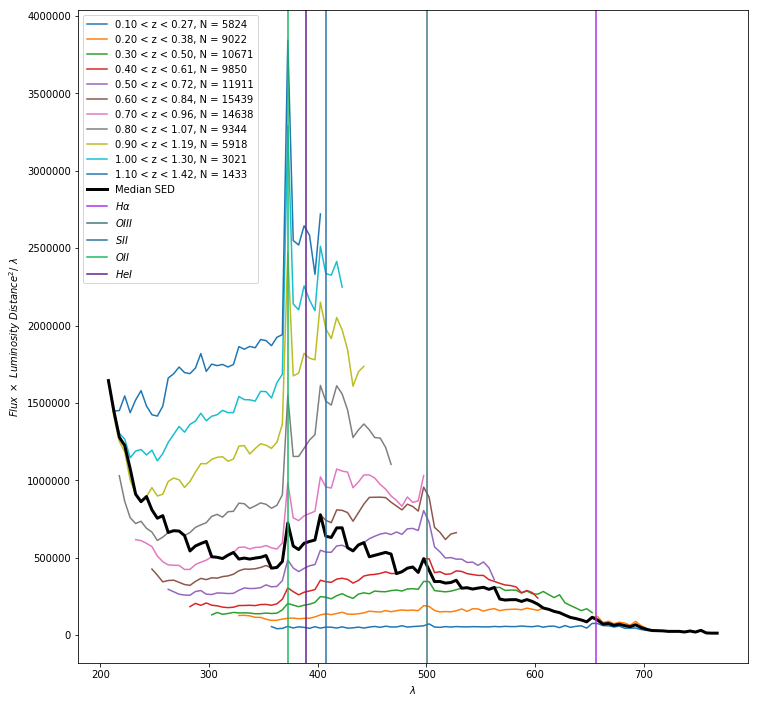

In [4]:
bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]


# bins = [[0.7,0.75],[0.75,0.8],[0.8,0.85]]
fig = plt.figure(figsize=(12,12))

band_obsframe = bands/(z_photos+1)
# print(band_obsframe.min(),band_obsframe.max())
band_bins = np.arange(200,860,5)

# print(band_obsframe,band_bins)
all_means = []
# print(data.loc[(data['imag']==0)|(data['rmag']==0)|(data['odds']<0)]['flux'])


for z_bin in bins:
    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe.loc[truth_table] #<---- remove rmgag=imag=0 and odds<0 results
    flux_sample = fluxs.loc[truth_table]
    lum_dist_sample = luminosity_distances[truth_table]
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = object_ids.loc[(z_photos >= z_bin[0]) & (z_photos <= z_bin[1])].unique().size
    
    digitized = np.digitize(lamb_sample,band_bins)
    binned_means = [np.nanmedian(flux_sample[digitized == i] * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
    all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
#     print (binned_means)
    
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
             label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl

# print(np.array(all_means))
plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[500.7,r'$OIII$'],[407.2,r'$SII$'],[372.8,r"$OII$"],[388.9,r'$HeI$']]
for line in emis_lines:
    random_ints = np.random.randint(256,size=3)
    plt.axvline(line[0],label=line[1],color='#{}{}{}'.\
                format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2)))

plt.xlabel(r'$\lambda$')
plt.ylabel(r'$Flux\ \times\ Luminosity\ Distance^2 /\ \lambda$')
plt.legend()
# plt.ylim([0,0.1])
#plt.xlim([200,680])
plt.show()


In [9]:
lum_dist_sample

array([7983.17477956, 7983.17477956, 7983.17477956, ..., 8130.32501358,
       8130.32501358, 8130.32501358])